In [1]:
#FUNÇÕES (RODE ANTES DO RESTO)

import numpy as np
import matplotlib.pyplot as plt
import random

# === Parte 1: Leitura do mapa ===
def carregar_mapa(caminho):
    return np.loadtxt(caminho, dtype=int)

# === Parte 2: Geração da máscara circular ===
def gerar_mascara_circular(raio):
    tamanho = 2 * raio + 1
    mascara = np.zeros((tamanho, tamanho), dtype=int)
    for i in range(tamanho):
        for j in range(tamanho):
            dx = i - raio
            dy = j - raio
            if np.sqrt(dx**2 + dy**2) <= raio:
                mascara[i][j] = 1
    return mascara

# === Parte 3: Aplicar máscara nos centros ===
def aplicar_mascara(mapa_original, centros, mascara):
    mapa = mapa_original.copy()
    raio = mascara.shape[0] // 2

    for centro_x, centro_y in centros:
        for i in range(mascara.shape[0]):
            for j in range(mascara.shape[1]):
                if mascara[i][j] == 1:
                    x = centro_x + i - raio
                    y = centro_y + j - raio
                    if 0 <= x < mapa.shape[0] and 0 <= y < mapa.shape[1]:
                        if mapa[x][y] == 1:
                            mapa[x][y] = 2
                        elif mapa[x][y] == 2:
                            mapa[x][y] = 3  # sobreposição
    return mapa




# === Parte 5: Cálculo do fitness ===
def calcular_fitness(num_circulos, mapa_original, centros, mascara, alpha=100, beta=1):
    mapa_coberto = aplicar_mascara(mapa_original, centros, mascara)
    total_para_cobrir = np.count_nonzero(mapa_original == 1)
    total_coberto = np.count_nonzero(mapa_coberto == 2)

    porcentagem_coberta = total_coberto / total_para_cobrir if total_para_cobrir > 0 else 0
    fitness = alpha * porcentagem_coberta - beta * len(centros)

    return fitness, mapa_coberto

# === Parte 6: Visualização ===
import matplotlib.colors as mcolors

def visualizar_mapa(mapa, centros=None, raio=None, rota=None):
    plt.figure(figsize=(10, 10))

    # Define cores para valores: 0=fundo, 1=área a cobrir, 2=coberta, 3=sobreposição
    cores = ['black', 'lightgrey', 'white', 'lightcyan']
    cmap = mcolors.ListedColormap(cores)

    bounds = [0, 0.5, 1.5, 2.5, 3.5]  # para separar as classes
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.imshow(mapa, cmap=cmap, norm=norm)

    # Plota os círculos da cobertura
    if centros is not None and raio is not None:
        for centro_x, centro_y in centros:
            circulo = plt.Circle((centro_y, centro_x), raio, color='blue', fill=False, linewidth=1.5)
            plt.gca().add_patch(circulo)

    # Plota a rota TSP
    if rota is not None and centros is not None:
        rota_coords = [centros[i] for i in rota]
        rota_x, rota_y = zip(*rota_coords)
        plt.plot(rota_y, rota_x, color='red', linewidth=2, marker='o')  # Perceba: inverte y e x pra plotagem correta

    plt.title('Cobertura Gerada (com sobreposição azul claro e rota TSP em vermelho)')
    plt.axis('off')
    plt.show()


In [2]:
#GERAR MALHA
import numpy as np

def gerar_malha(x1, y1, x2, y2, R, mapa):
    """
    Gera uma malha hexagonal a partir dos pontos (x1, y1) e (x2, y2) com raio R,
    cobrindo a Área A (mapa == 1).
    """
    coords = []
    max_x, max_y = mapa.shape

    
    # Vetor base (direção principal)
    dx = x2 - x1
    dy = y2 - y1
    distancia_base = np.sqrt(dx**2 + dy**2)

    if distancia_base == 0:
        print("Erro: (x1, y1) e (x2, y2) não podem ser iguais.")
        return []

    # Unidade do vetor base
    ux = dx / distancia_base
    uy = dy / distancia_base

    # Vetor perpendicular (para linhas)
    perp_ux = -uy
    perp_uy = ux

    # Distâncias entre centros
    dist_entre_circulos = R * np.sqrt(3)      # entre colunas
    dist_entre_linhas = (3 / 2) * R           # entre linhas
    fase = 0.5 * R * np.sqrt(3)               # deslocamento para colunas ímpares

    # Calcular alcance necessário para cobrir o mapa inteiro
    diag = np.sqrt(max_x**2 + max_y**2)
    max_linhas = int(diag / dist_entre_linhas) + 5
    max_colunas = int(diag / dist_entre_circulos) + 5

    for linha in range(-max_linhas, max_linhas + 1):
        offset_x = linha * dist_entre_linhas * perp_ux
        offset_y = linha * dist_entre_linhas * perp_uy
        fase_offset = (linha % 2) * fase

        for coluna in range(-max_colunas, max_colunas + 1):
            desloc_x = (coluna * dist_entre_circulos + fase_offset) * ux
            desloc_y = (coluna * dist_entre_circulos + fase_offset) * uy

            cx = x1 + desloc_x + offset_x
            cy = y1 + desloc_y + offset_y

            cx_int = int(round(cx))
            cy_int = int(round(cy))

            if 0 <= cx_int < max_x and 0 <= cy_int < max_y:
                if mapa[cx_int, cy_int] == 1:
                    coords.append((cx_int, cy_int))
    
    return coords


In [3]:
#ACHA ROTA

import numpy as np
import random
import matplotlib.pyplot as plt

def genetic_tsp(coordinates, generations, population_size=100, crossover_rate=0.9, mutation_rate=0.1, elitism=False):
    coordinates = np.array(coordinates)
    num_cities = len(coordinates)

    # Calcula a matriz de distâncias
    def euclidean_distance(p1, p2):
        return np.linalg.norm(p1 - p2)

    dist_matrix = np.array([
        [euclidean_distance(coordinates[i], coordinates[j]) for j in range(num_cities)]
        for i in range(num_cities)
    ])

    # Função para calcular distância total de uma rota
    def calculate_distance(route):
        return sum(dist_matrix[route[i], route[i + 1]] for i in range(num_cities - 1)) + dist_matrix[route[-1], route[0]]

    # Geração inicial
    def generate_population():
        return np.array([np.random.permutation(num_cities) for _ in range(population_size)])

    # Seleção por torneio
    def tournament_selection(population):
        i1, i2 = random.sample(range(population_size), 2)
        return population[i1] if calculate_distance(population[i1]) < calculate_distance(population[i2]) else population[i2]

    # Crossover por ordem
    def order_crossover(parent1, parent2):
        start, end = sorted(random.sample(range(num_cities), 2))
        child = [-1] * num_cities
        child[start:end] = parent1[start:end]
        remaining = [gene for gene in parent2 if gene not in child]
        j = 0
        for i in range(num_cities):
            if child[i] == -1:
                child[i] = remaining[j]
                j += 1
        return np.array(child)

    # Mutação simples
    def mutate(route):
        if random.random() < mutation_rate:
            i, j = random.sample(range(num_cities), 2)
            route[i], route[j] = route[j], route[i]
        return route

    # Algoritmo genético principal
    population = generate_population()
    best_route = min(population, key=calculate_distance)
    best_distance = calculate_distance(best_route)

    for gen in range(generations):
        new_population = []

        if elitism:
            new_population.append(best_route)

        while len(new_population) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            if random.random() < crossover_rate:
                child = order_crossover(parent1, parent2)
            else:
                child = parent1.copy()
            child = mutate(child)
            new_population.append(child)

        population = np.array(new_population)
        current_best = min(population, key=calculate_distance)
        current_best_distance = calculate_distance(current_best)

        if current_best_distance < best_distance:
            best_route = current_best
            best_distance = current_best_distance

        if gen % 100 == 0:
            print(f"Geração {gen} | Melhor distância: {best_distance:.2f}")

    return best_route, best_distance




Erro: (x1, y1) e (x2, y2) não podem ser iguais.
Erro: (x1, y1) e (x2, y2) não podem ser iguais.
x1, y1: (128, 124)
x2, y2: (128, 43)
Geração 0 | Melhor distância: 8311.28
Geração 100 | Melhor distância: 5003.95
Geração 200 | Melhor distância: 4120.37
Geração 300 | Melhor distância: 4024.71
Geração 400 | Melhor distância: 3960.20
Centros válidos: 39
Total para cobrir:  221478
Total coberto:  217479
Faltando:  3999


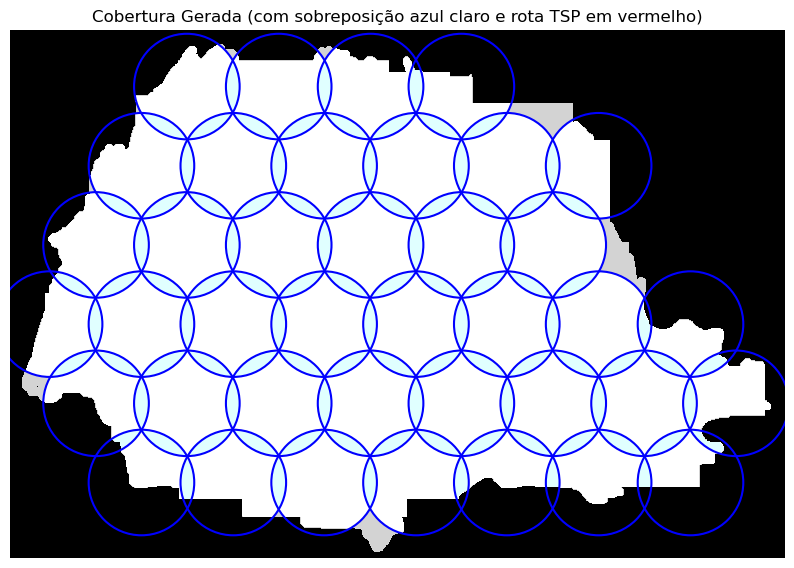

In [5]:
#GA COM MALHA

import numpy as np
from ga import gago
from utilities import bits2bytes
import matplotlib.pyplot as plt
from functools import partial
import subprocess
import sys
sys.path.append(r'C:\Users\avanc\Desktop\trabalho_py-main')

# Função de fitness usando remapeamento por módulo em vez de clip
def fit_func(bits, mapa_original, mascara, R):
    X = bits2bytes(bits, 'uint8').astype(int)

    # Garante que temos pelo menos 4 variáveis
    if len(X) < 4:
        return 1e9

    # Limita os valores para o intervalo desejado [1, 128]
    x1 = max(1, min(128, X[0]))
    y1 = max(1, min(128, X[1]))
    x2 = max(1, min(128, X[2]))
    y2 = max(1, min(128, X[3]))

    coords_malha = gerar_malha(x1, y1, x2, y2, R, mapa_original)

    if len(coords_malha) == 0:
        return 1e9

    mapa_coberto = aplicar_mascara(mapa_original, coords_malha, mascara)

    total_para_cobrir = np.count_nonzero(mapa_original == 1)
    total_coberto = np.count_nonzero((mapa_coberto == 2) | (mapa_coberto == 3))
    sobreposicoes = np.count_nonzero(mapa_coberto == 3)

    faltando = total_para_cobrir - total_coberto
    erro = faltando + len(coords_malha)  # Penaliza por número de círculos usados

    return erro


# Função principal
def main():
    caminho_mapa = "D:\\Downloads\\mapa.dat"
    raio = 50

    mapa = carregar_mapa(caminho_mapa)
    mascara = gerar_mascara_circular(raio)

    gaoptions = {
        "PopulationSize": 10,
        "Generations": 10,
        "InitialPopulation": [],
        "MutationFcn": 0.15,
        "EliteCount": 2,
    }


    fit = partial(fit_func, mapa_original=mapa, mascara=mascara, R=raio)
    result = gago(fit, 32, gaoptions)


    # Extrai a melhor solução
    bits_optimizado = result[0]

    # Decodifica os bits para inteiros no intervalo [1, 128]
    X = bits2bytes(bits_optimizado, 'uint8').astype(int)
    x1 = max(1, min(128, X[0]))
    y1 = max(1, min(128, X[1]))
    x2 = max(1, min(128, X[2]))
    y2 = max(1, min(128, X[3]))

    print(f"x1, y1: ({x1}, {y1})")
    print(f"x2, y2: ({x2}, {y2})")

    # Gera a malha com os melhores parâmetros
    centros = gerar_malha(x1, y1, x2, y2, raio, mapa)
    rota, distancia = genetic_tsp(centros, 500)

    print(f"Centros válidos: {len(centros)}")


    # Aplica a máscara e visualiza
    mapa_coberto = aplicar_mascara(mapa, centros, mascara)

    total_para_cobrir = np.count_nonzero(mapa == 1)
    total_coberto = np.count_nonzero((mapa_coberto == 2) | (mapa_coberto == 3))
    faltando = total_para_cobrir - total_coberto
    print("Total para cobrir: ", total_para_cobrir)
    print("Total coberto: ", total_coberto)
    print("Faltando: ",faltando)

    visualizar_mapa(mapa_coberto, centros, raio)

if __name__ == "__main__":
    main()
#